In [1]:
import numpy as np
import pandas as pd
import json
from epilepsypcm.utils.outcome_params import seizure_onset_zone, engel_score

# INPUT
# patient = string format, patient number
# paths = path to CCEP response files, in os format
# OUTPUT
# df = dataframe for one patient with
#       X features with columns: chNames, significant, n1, n2, p2 z scores,
#       n1, n2, p2 latencies, and flipped
#       and associated y outcome labels
def make_df(patient, paths):
    #extracting info from each response file
    n = 0
    stimChs = []
    for i in range(len(paths)):
        chNames = []
        # load info into python dictionary
        data = json.load(open(paths[i]))

        # Get list of channel names
        for key in data["time"]: chNames.append(key)

        # loop over each channel, and extract average time series and information about the peaks

        if n < 1:
            avgResp = np.empty((len(paths), len(chNames), len(data['time'][chNames[0]])))
            significant = np.empty((len(paths), len(chNames)))
            n1Zscore = np.empty((len(paths), len(chNames)))
            n2Zscore = np.empty((len(paths), len(chNames)))
            p2Zscore = np.empty((len(paths), len(chNames)))
            n1Latency = np.empty((len(paths), len(chNames)))
            n2Latency = np.empty((len(paths), len(chNames)))
            p2Latency = np.empty((len(paths), len(chNames)))
            flipped = np.empty((len(paths), len(chNames)))
            n += 1
            samplingRate = np.empty((len(paths)))
            window = np.empty((len(paths), 2))

        for j in range(len(chNames)):
            avgResp[i][j] = data['time'][chNames[j]]
            significant[i][j] = data['significant'][chNames[j]]
            n1Zscore[i][j] = data['zscores'][chNames[j]]['n1'][1]
            n2Zscore[i][j] = data['zscores'][chNames[j]]['n2'][1]
            p2Zscore[i][j] = data['zscores'][chNames[j]]['p2'][1]
            n1Latency[i][j] = data['zscores'][chNames[j]]['n1'][0] + data['window'][0] * data["samplingRate"] / 1000
            n2Latency[i][j] = data['zscores'][chNames[j]]['n2'][0] + data['window'][0] * data["samplingRate"] / 1000
            p2Latency[i][j] = data['zscores'][chNames[j]]['p2'][0] + data['window'][0] * data["samplingRate"] / 1000
            flipped[i][j] = data['zscores'][chNames[j]]['flipped']

        samplingRate[i] = data["samplingRate"]
        window[i] = data['window']
        stimChs = stimChs + [paths[i].split("_")[1] + "_" + paths[i].split("_")[2]]*len(chNames)


    # creating dataframe

    df = pd.DataFrame()
    df["stimChs"] = stimChs
    df["respChs"] = chNames * len(paths)
    df["significant"] = significant.flatten()
    df["n1Zscore"] = n1Zscore.flatten()
    df["n2Zscore"] = n2Zscore.flatten()
    df["p2Zscore"] = p2Zscore.flatten()
    df["n1Latency"] = n1Latency.flatten()
    df["n2Latency"] = n2Latency.flatten()
    df["p2Latency"] = p2Latency.flatten()
    df["flipped"] = flipped.flatten()

    # Dropped rows for stimulating channels since they only
    # contain stimulating waveforms / artifacts / saturated signals
    # Also zero out rows with latency values of -999.0

    # drop rows in the dataframe with latency values of -999.0
    df = df.drop(df.loc[df["n1Latency"] == -999.0].index)
    df = df.drop(df.loc[df["n1Latency"] == -499.0].index)

    # adding dataframe outcome values (1 if in SOZ, 0 if not)
    df["outcome"] = np.zeros(df.shape[0])
    if engel_score[patient] == "1":
        if seizure_onset_zone[patient] != "None":
            for node in seizure_onset_zone[patient]:
                for channel in df["respChs"]:
                    if node in channel:
                        df.loc[df['respChs']==channel, ['outcome']] = 1
    return df

# Function that takes in the location of all patient folders and engel
# score of interest, and returns a nested list of dataframes for each patient
# INPUT:
# base_path = string, file location to base folder that contains all patient folders
# engel_score = string, target engel score to get dataframe for (ex. "1")
#               can currently only handle "1" and "2"
# OUTPUT:
# positive_dataframes = a nested list, where [patient number (string), dataframe].


In [2]:
def df_processing(D):
    D.reset_index(drop = True, inplace=True)

    #Find channel names that exists both in stimChs and respChs - only account channels that have arrows going out and in
    overlap = []
    for channel in D.respChs.unique():
        if channel in D.stimChs.unique():
            overlap.append(channel)

    #Keep only the response that were stimulated in responded in the channel in overlap list
    dropindxs = []
    for i in range(len(D)):
        if D.iloc[i].stimChs not in overlap or D.iloc[i].respChs not in overlap:
                dropindxs.append(i)
    D.drop(dropindxs,inplace=True)
    D.reset_index(drop = True, inplace=True)

    D.n1Zscore = abs(D.n1Zscore)
    D.n2Zscore = abs(D.n2Zscore)
    D.p2Zscore = abs(D.p2Zscore)
    
    #start processing
    df = pd.DataFrame()
    ChNames = overlap
    Outcomes = np.array([])
    Per_Significant_Resp = np.array([])
    Per_Significant_Stim = np.array([])
    N1_Avg_Resp = np.array([])
    N1_STV_Resp = np.array([])
    N2_Avg_Resp = np.array([])
    N2_STV_Resp = np.array([])
    P2_Avg_Resp = np.array([])
    P2_STV_Resp = np.array([])
    N1_Avg_Stim = np.array([])
    N1_STV_Stim = np.array([])
    N2_Avg_Stim = np.array([])
    N2_STV_Stim = np.array([])
    P2_Avg_Stim = np.array([])
    P2_STV_Stim = np.array([])

    for channel in ChNames:
        Resp = D[D.respChs == channel]
        Stim = D[D.stimChs == channel]

        Outcomes = np.append(Outcomes,Resp[:1].outcome)

        Per_Significant_Resp = np.append(Per_Significant_Resp,
                                         sum(Resp.significant/len(Resp)))
        Per_Significant_Stim = np.append(Per_Significant_Stim,
                                         sum(Stim.significant/len(Stim)))

        N1_Avg_Resp = np.append(N1_Avg_Resp,sum(Resp.n1Zscore)/len(Resp))
        N1_STV_Resp = np.append(N1_STV_Resp,np.std(Resp.n1Zscore))

        N2_Avg_Resp = np.append(N2_Avg_Resp,sum(Resp.n2Zscore)/len(Resp))
        N2_STV_Resp = np.append(N2_STV_Resp,np.std(Resp.n2Zscore))

        P2_Avg_Resp = np.append(P2_Avg_Resp,sum(Resp.p2Zscore)/len(Resp))
        P2_STV_Resp = np.append(P2_STV_Resp,np.std(Resp.p2Zscore))

        N1_Avg_Stim = np.append(N1_Avg_Stim,sum(Stim.n1Zscore)/len(Stim))
        N1_STV_Stim = np.append(N1_STV_Stim,np.std(Stim.n1Zscore))

        N2_Avg_Stim = np.append(N2_Avg_Stim,sum(Stim.n2Zscore)/len(Stim))
        N2_STV_Stim = np.append(N2_STV_Stim,np.std(Stim.n2Zscore))

        P2_Avg_Stim = np.append(P2_Avg_Stim,sum(Stim.p2Zscore)/len(Stim))
        P2_STV_Stim = np.append(P2_STV_Stim,np.std(Stim.p2Zscore))



    df['Channels'] = ChNames
    df['outcome'] = Outcomes
    df['SigResp'] = Per_Significant_Resp
    df['SigStim'] = Per_Significant_Stim
    df['N1RespAvg'] = N1_Avg_Resp
    df['N1RespSDV'] = N1_STV_Resp
    df['N2RespAvg'] = N2_Avg_Resp
    df['N2RespSDV'] = N2_STV_Resp
    df['P2RespAvg'] = P2_Avg_Resp
    df['P2RespSDV'] = P2_STV_Resp
    df['N1StimAvg'] = N1_Avg_Stim
    df['N1StimSDV'] = N1_STV_Stim
    df['N2StimAvg'] = N2_Avg_Stim
    df['N2StimSDV'] = N2_STV_Stim
    df['P2StimAvg'] = P2_Avg_Stim
    df['P2StimSDV'] = P2_STV_Stim

    return df

In [3]:
import glob
import os
from pathlib import Path

def get_df_list(base_path, engel):
    patient_files = os.listdir(base_path)

    positive_dataframes = []
    for file in patient_files:
        if (file[0] == "P") & (file != "PY16N006"):
            response_path = base_path + file + '/ResponseInfo/CCEP'
            response_files_path = glob.glob(response_path + '/*.json', recursive=True)

            # Getting individual dataframe for positive patients
            patient = file
            if file in engel_score.keys():  # if we currently have the file's engel score
                if engel_score[patient] == engel:  # if the engel score is 1
                    df = make_df(patient, response_files_path)
                    positive_dataframes.append([patient, df])

    return positive_dataframes

# Function that combines dataframes for all patients of a particular
# engel class
# INPUT:
# base_path = string, file location to base folder that contains all patient folders
# engel_score = string, target engel score to get dataframe for (ex. "1")
#               can currently only handle "1" and "2"
# balance (OPTIONAL, default = None) = "None", "upsample", or "downsample"
#          will upsample minority class or downsample majority class to balance
#           the data
# OUTPUT:
# all_positive_patients = a concatonated dataframe of all patients


In [4]:

from sklearn.utils import resample

def concat_dfs(base_path, engel, balance = None):

    patient_files = os.listdir(base_path)

    full_df = pd.DataFrame()
    for file in patient_files:
        if (file[0] == "P") & (file != "PY16N006"):
            response_path = base_path + file + '/ResponseInfo/CCEP'
            response_files_path = glob.glob(response_path + '/*.json', recursive=True)

            # Getting individual dataframe for positive patients
            patient = file
            if file in engel_score.keys():  # if we currently have the file's engel score
                if engel_score[patient] == engel:  # if the engel score is 1
                    df = make_df(patient, response_files_path)
                    df = df_processing(df)
                    full_df = pd.concat([full_df, df])
                    
        print('%s done...'%patient)

    # seperate dataframes for class
    df_majority = full_df[full_df.outcome == 0]
    df_minority = full_df[full_df.outcome == 1]

    # upsample data if balance parameter is set to "Upsample" or "upsample"
    if (balance == "upsample") | (balance == "Upsample"):
        # Upsample minority class
        df_minority_upsampled = resample(df_minority,
                                         replace=True,  # sample with replacement
                                         n_samples=full_df["outcome"].value_counts()[0.0],
                                         # to match majority class
                                         random_state=123)  # reproducible results


        # combine dataframes
        full_df = pd.concat([df_majority, df_minority_upsampled])

    # downsample data if balance parameter is set to "downsample" or "Downsample"
    elif (balance == "downsample") | (balance == "Downsample"):
        # downsample majority class
        # downsample majority class
        df_majority_downsampled = resample(df_majority,
                                           replace=False,  # sample without replacement
                                           n_samples= full_df["outcome"].value_counts()[1.0],
                                           # to match minority class
                                           random_state=123)  # reproducible results


        full_df = pd.concat([df_majority_downsampled, df_minority])

    return full_df


# Function that upsamples or downsamples a training set to balance classes
# INPUT:
# X_train = output from train_test_split function
# y_train = output from train_test_split function
# balance = "upsample", or "downsample"
#          will upsample minority class or downsample majority class to balance
#           the data
# OUTPUT:
# X_train = new balanced X training data
# y_train = new balanced y training data

In [5]:
from sklearn.utils import resample
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

def class_balance(X_train, y_train, balance):
    full_df = pd.concat([X_train, y_train], axis = 1)

    # seperate dataframes for class
    df_majority = full_df[full_df.outcome == 0]
    df_minority = full_df[full_df.outcome == 1]

    # upsample data if balance parameter is set to "Upsample" or "upsample"
    if (balance == "upsample") | (balance == "Upsample"):
        # Upsample minority class
        df_minority_upsampled = resample(df_minority,
                                        replace=True,  # sample with replacement
                                        n_samples=full_df["outcome"].value_counts()[0.0],
                                        # to match majority class
                                        random_state=123)  # reproducible results


        # combine dataframes
        full_df = pd.concat([df_majority, df_minority_upsampled])

    # downsample data if balance parameter is set to "downsample" or "Downsample"
    elif (balance == "downsample") | (balance == "Downsample"):
        # downsample majority class
        # downsample majority class
        df_majority_downsampled = resample(df_majority,
                                        replace=False,  # sample without replacement
                                        n_samples= full_df["outcome"].value_counts()[1.0],
                                        # to match minority class
                                        random_state=123)  # reproducible results


        full_df = pd.concat([df_majority_downsampled, df_minority])

    X_train = full_df.drop(columns = ["outcome"])
    y_train = full_df["outcome"]
    
    return X_train, y_train


In [6]:
base_path = '/Users/zhonglelin/Desktop/data/'



#Function to get the concatenated dataframe for all positive patients
## balance parameter can be changed to "None", "upsample", or "downsample"
all_positive_patients = concat_dfs(base_path, "1")

PY21N008 done...
PY21N006 done...
PY20N001 done...
PY16N008_3D.png done...
PY21N007 done...
PY17N020 done...
PY18N007 done...
PY17N018 done...
PY17N018 done...
PY16N011 done...
PY19N009 done...
PY16N008_2D.png done...
PY17N019 done...
PY19N012 done...
PY19N015 done...
PY19N023 done...
PY19N024 done...
PY18N015 done...
PY18N013 done...
PY17N005 done...
PY21N014 done...
PY21N022 done...
PY20N012 done...
PY20N012 done...
PY21N012 done...
PY20N002 done...
PY20N005 done...
PY20N005 done...
PY21N002 done...
PY21N002 done...
PY20N003 done...
PY21N004 done...
PY18N003 done...
PY18N003 done...
PY19N005 done...
PY16N013 done...
PY17N013 done...
PY17N014 done...
PY18N002 done...
PY18N011 done...
PY18N016 done...
PY19N011 done...
PY19N018 done...
PY19N020 done...
PY17N008 done...
PY17N008 done...
PY17N008 done...
PY19N026 done...
PY16N008 done...
PY19N017 done...
PY21N010 done...
PY21N020 done...
PY20N016 done...
PY20N011 done...


In [7]:
all_positive_patients.reset_index(drop = True, inplace=True)
all_positive_patients

,Channels,outcome,SigResp,SigStim,N1RespAvg,N1RespSDV,N2RespAvg,N2RespSDV,P2RespAvg,P2RespSDV,N1StimAvg,N1StimSDV,N2StimAvg,N2StimSDV,P2StimAvg,P2StimSDV
0,LA9_LA10,1.0,0.000000,0.250000,1.530459,1.134169,2.040546,1.369091,1.304096,0.892887,7.178516,10.790559,6.536859,6.383906,5.785279,7.331337
1,LAH1_LAH2,1.0,0.076923,0.250000,7.062089,20.678040,3.320937,2.795194,2.178348,2.563587,7.883750,16.334814,4.921208,3.029861,2.352152,1.803711
2,LAH8_LAH9,0.0,0.307692,0.125000,4.032683,2.995624,3.450575,2.883998,2.376435,2.139730,2.505806,2.164878,2.190308,1.489418,2.033410,2.112725
3,LPH1_LPH2,0.0,0.115385,0.333333,6.522655,17.219698,3.369771,3.506524,2.281413,3.303814,6.505212,8.264811,4.630948,3.574869,4.187831,3.626223
4,LPH7_LPH8,0.0,0.307692,0.083333,7.304854,10.728727,4.610356,4.159990,3.468193,2.645476,2.823084,2.925869,1.606341,1.075715,1.461462,1.012732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,RMBT2_RMBT3,0.0,0.250000,0.375000,10.029460,19.122649,6.391055,5.733855,5.789198,8.766071,13.594587,19.912187,6.165966,5.398174,7.684954,9.885282
305,RPTI19_RPTI20,0.0,0.250000,0.250000,13.323164,20.134989,4.393888,4.366079,7.924898,11.404889,14.164498,21.710392,6.080624,5.949018,6.706642,9.411200
306,RPTS60_RPTS61,0.0,0.125000,0.250000,9.883556,20.481622,4.603904,6.318618,5.756485,9.535264,9.726907,15.484303,6.323287,5.584253,7.569330,11.384782
307,RPFS4_RPFS5,0.0,0.000000,0.000000,2.462636,1.320800,3.635232,2.139720,1.444058,0.870770,1.916434,1.392987,3.160595,1.173929,3.855516,3.516656


In [13]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.manifold import TSNE 
from sklearn.preprocessing import StandardScaler 
from mpl_toolkits.mplot3d import Axes3D

In [14]:
x_data = all_positive_patients.drop(columns=['outcome','Channels'])
y_true = all_positive_patients.iloc[:, 1].values
x_data

,SigResp,SigStim,N1RespAvg,N1RespSDV,N2RespAvg,N2RespSDV,P2RespAvg,P2RespSDV,N1StimAvg,N1StimSDV,N2StimAvg,N2StimSDV,P2StimAvg,P2StimSDV
0,0.000000,0.250000,1.530459,1.134169,2.040546,1.369091,1.304096,0.892887,7.178516,10.790559,6.536859,6.383906,5.785279,7.331337
1,0.076923,0.250000,7.062089,20.678040,3.320937,2.795194,2.178348,2.563587,7.883750,16.334814,4.921208,3.029861,2.352152,1.803711
2,0.307692,0.125000,4.032683,2.995624,3.450575,2.883998,2.376435,2.139730,2.505806,2.164878,2.190308,1.489418,2.033410,2.112725
3,0.115385,0.333333,6.522655,17.219698,3.369771,3.506524,2.281413,3.303814,6.505212,8.264811,4.630948,3.574869,4.187831,3.626223
4,0.307692,0.083333,7.304854,10.728727,4.610356,4.159990,3.468193,2.645476,2.823084,2.925869,1.606341,1.075715,1.461462,1.012732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,0.250000,0.375000,10.029460,19.122649,6.391055,5.733855,5.789198,8.766071,13.594587,19.912187,6.165966,5.398174,7.684954,9.885282
305,0.250000,0.250000,13.323164,20.134989,4.393888,4.366079,7.924898,11.404889,14.164498,21.710392,6.080624,5.949018,6.706642,9.411200
306,0.125000,0.250000,9.883556,20.481622,4.603904,6.318618,5.756485,9.535264,9.726907,15.484303,6.323287,5.584253,7.569330,11.384782
307,0.000000,0.000000,2.462636,1.320800,3.635232,2.139720,1.444058,0.870770,1.916434,1.392987,3.160595,1.173929,3.855516,3.516656


5
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.001s...
[t-SNE] Computed neighbors for 309 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 1.976830
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.514267
[t-SNE] KL divergence after 1000 iterations: 0.746223


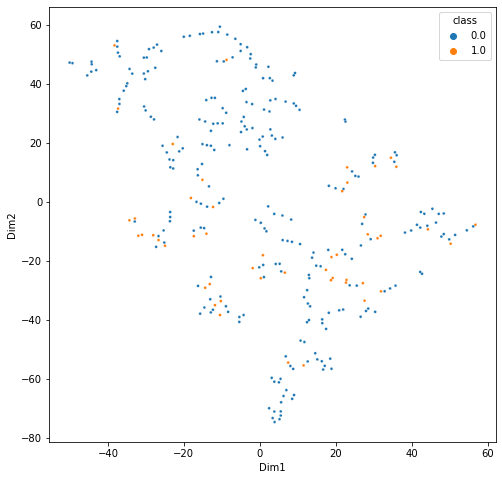

10
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 2.759184
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.685211
[t-SNE] KL divergence after 1000 iterations: 0.694542


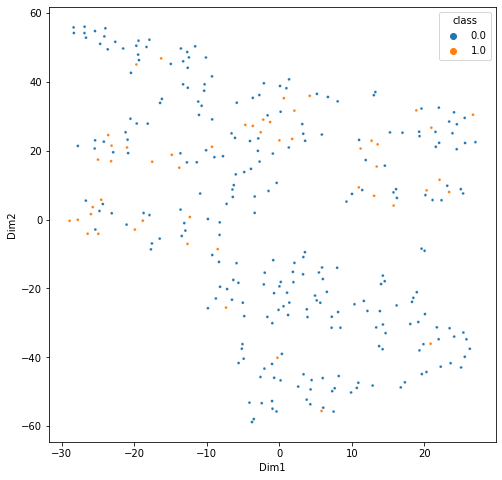

15
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.001s...
[t-SNE] Computed neighbors for 309 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 3.306088
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.366905
[t-SNE] KL divergence after 1000 iterations: 0.625546


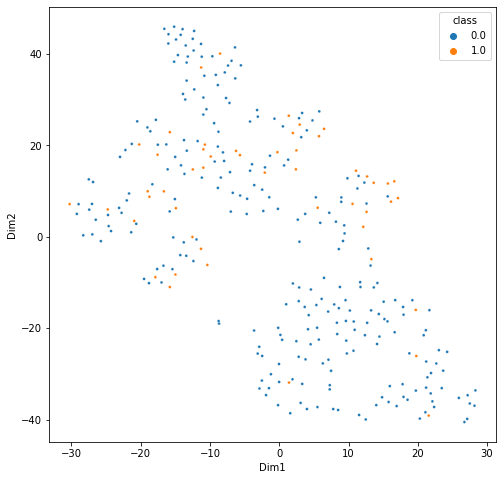

20
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 3.761184
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.465370
[t-SNE] KL divergence after 1000 iterations: 0.601653


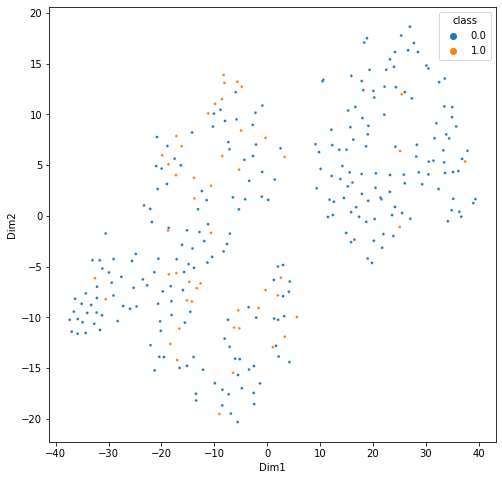

25
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 4.159045
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.671963
[t-SNE] KL divergence after 1000 iterations: 0.599213


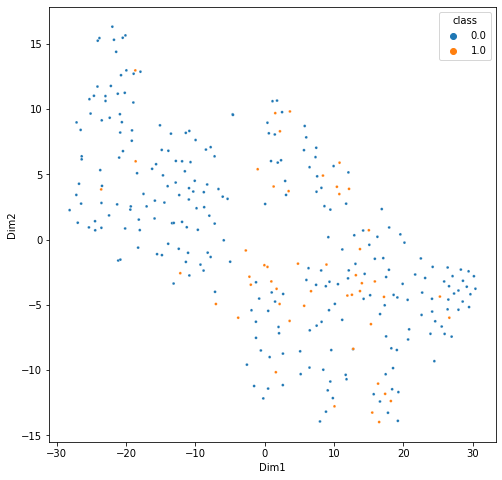

30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.001s...
[t-SNE] Computed neighbors for 309 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 4.515337
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.568344
[t-SNE] KL divergence after 1000 iterations: 0.565376


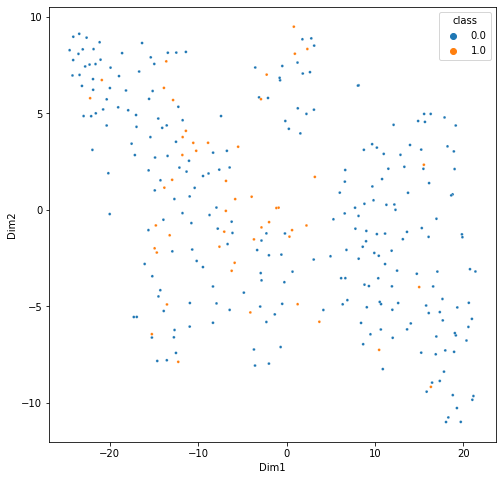

35
[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.001s...
[t-SNE] Computed neighbors for 309 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 4.835273
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.586231
[t-SNE] KL divergence after 1000 iterations: 0.446219


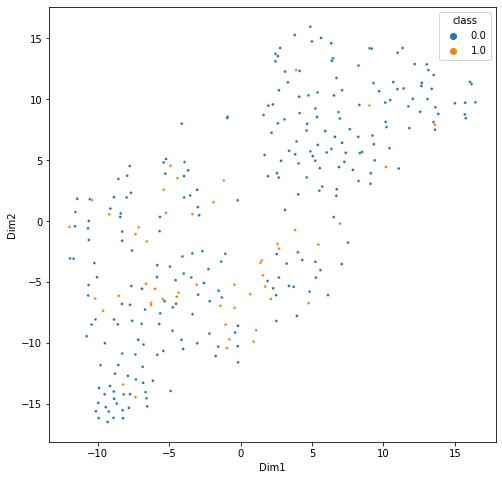

40
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.001s...
[t-SNE] Computed neighbors for 309 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 5.127687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.940643
[t-SNE] KL divergence after 1000 iterations: 0.490394


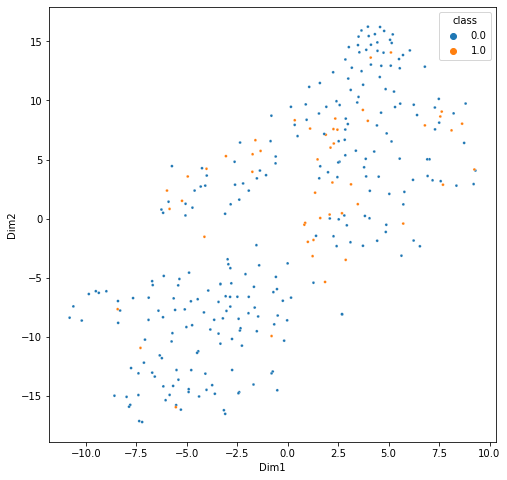

45
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.001s...
[t-SNE] Computed neighbors for 309 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 5.401635
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.310417
[t-SNE] KL divergence after 850 iterations: 0.387841


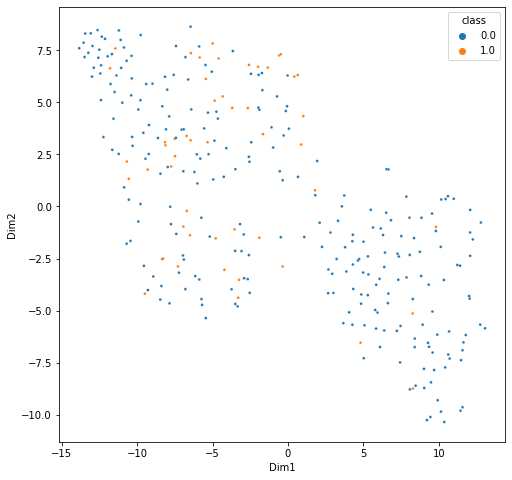

In [15]:

for i in range (5,50,5):
    p  =+ i
    print(p)
    tsne = TSNE(verbose = 1, n_components=2, init='random', perplexity=p, learning_rate=100)
    # X_std = StandardScaler().fit_transform(x_data) 
    X_tsne = tsne.fit_transform(x_data) 
    X_tsne_data = np.vstack((X_tsne.T, y_true)).T 
    df_tsne = pd.DataFrame(X_tsne_data, columns=['Dim1', 'Dim2','class']) 
    df_tsne.head()
    plt.figure(figsize=(8, 8)) 
    sns.scatterplot(data=df_tsne, hue='class', x='Dim1', y='Dim2',s=8) 
    plt.show()

5
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.001s...
[t-SNE] Computed neighbors for 309 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 1.976830
[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.926163
[t-SNE] KL divergence after 1000 iterations: 1.880579


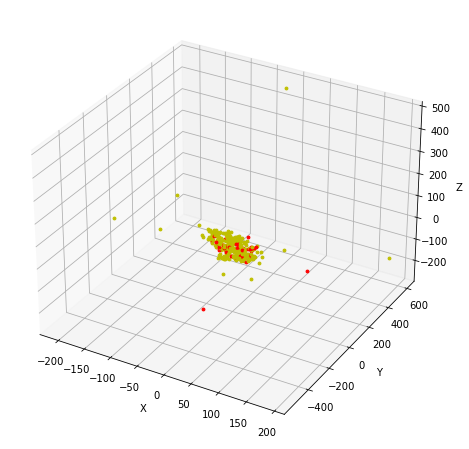

10
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 2.759184
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.054474
[t-SNE] KL divergence after 1000 iterations: 0.801638


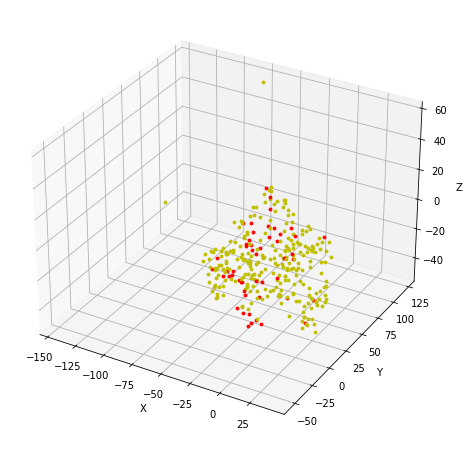

15
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 3.306088
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.168152
[t-SNE] KL divergence after 1000 iterations: 0.787510


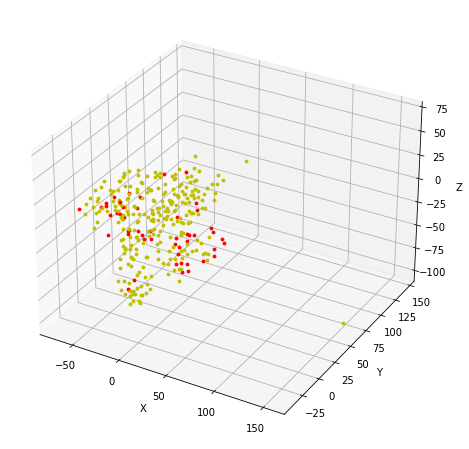

20
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 3.761184
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.873245
[t-SNE] KL divergence after 1000 iterations: 0.928642


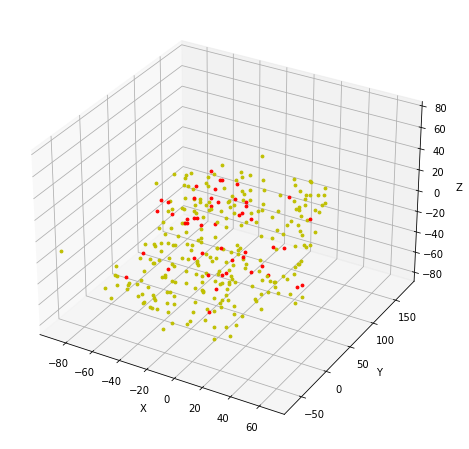

25
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 4.159045
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.309708
[t-SNE] KL divergence after 1000 iterations: 0.730168


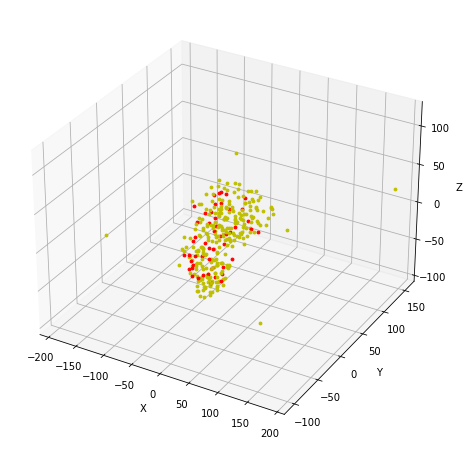

30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 4.515337
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.014893
[t-SNE] KL divergence after 1000 iterations: 0.615156


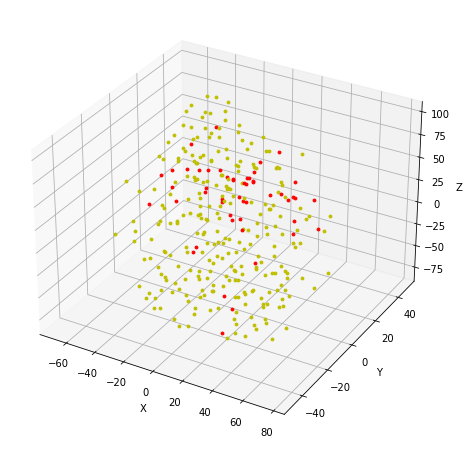

35
[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 4.835273
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.096809
[t-SNE] KL divergence after 1000 iterations: 0.549403


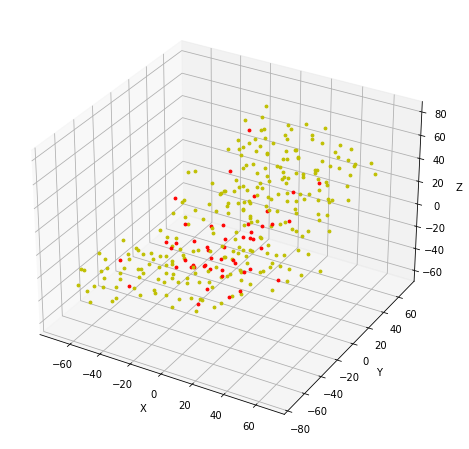

40
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 5.127687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.359177
[t-SNE] KL divergence after 1000 iterations: 0.589249


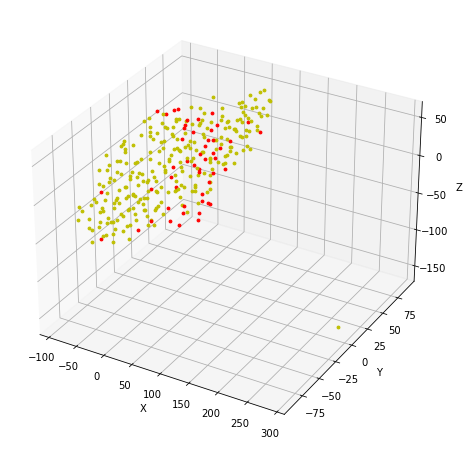

45
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 5.401635
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.293198
[t-SNE] KL divergence after 1000 iterations: 0.471171


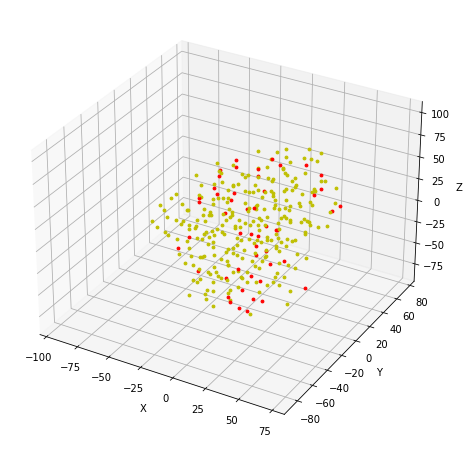

In [16]:
for i in range (5,50,5):
    p  =+ i
    print(p)
    tsne = TSNE(verbose = 1, n_components=3, init='random', perplexity = p, learning_rate=100)
    # X_std = StandardScaler().fit_transform(x_data) 
    X_tsne = tsne.fit_transform(x_data) 
    X_tsne_data = np.vstack((X_tsne.T, y_true)).T 
    df_tsne = pd.DataFrame(X_tsne_data, columns=['Dim1', 'Dim2','Dim3','class']) 
    df_tsne.head()
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    ax = plt.subplot(111, projection='3d')  
    for row in df_tsne.itertuples(): 
        x = getattr(row,'Dim1')
        y = getattr(row,'Dim2')
        z = getattr(row,'Dim3')
        if getattr(row,'_4') == 0.0:
            ax.scatter(x,y,z, c='y', s=8) 
        elif getattr(row,'_4') == 1.0:
            ax.scatter(x,y,z, c='r',s=8) 
    ax.set_zlabel('Z')  
    ax.set_ylabel('Y')
    ax.set_xlabel('X')
    # ax.scatter(data=df_tsne, hue='class', x='Dim1', y='Dim2', z = 'Dim3')
    plt.show()